# Import, Load and Preprocessing Data

In [ ]:
!pip install transformers datasets accelerate -U

import pandas as pd
import numpy as np
import re
import string
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from transformers import EarlyStoppingCallback
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import (
    DistilBertTokenizerFast, DistilBertForSequenceClassification,
    RobertaTokenizerFast, RobertaForSequenceClassification,
    Trainer, TrainingArguments
)

# Download resources untuk teks cleaning
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

# Setup Device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Menggunakan device: cuda


[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Load dataset
df = pd.read_csv('suicide_detection.csv')

df = df.sample(n=12000, random_state=42).reset_index(drop=True)

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print(f"Data berhasil di-limit menjadi: {len(df)} baris")
print(f"Distribusi Kelas:\n{df['class'].value_counts()}")

Data berhasil di-limit menjadi: 12000 baris
Distribusi Kelas:
class
non-suicide    6029
suicide        5971
Name: count, dtype: int64


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

print("Cleaning 10.000 data...")
df['cleaned_text'] = df['text'].astype(str).apply(clean_text)

df = df[df['cleaned_text'].str.strip() != ""]

print(f"Pembersihan Selesai. Sisa data siap training: {len(df)}")

Cleaning 10.000 data...
Pembersihan Selesai. Sisa data siap training: 11996


In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['class'])

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['cleaned_text'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42
)

print(f"Data Training: {len(X_train_raw)}")
print(f"Data Testing: {len(X_test_raw)}")

Data Training: 9596
Data Testing: 2400


# LSTM

In [ ]:
vocab_size = 20000
max_length = 150
tokenizer_lstm = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer_lstm.fit_on_texts(X_train_raw)

X_train_lstm = pad_sequences(tokenizer_lstm.texts_to_sequences(X_train_raw), maxlen=max_length)
X_test_lstm = pad_sequences(tokenizer_lstm.texts_to_sequences(X_test_raw), maxlen=max_length)

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length),
    tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

print("Training LSTM...")
history_lstm = model_lstm.fit(
    X_train_lstm, y_train,
    epochs=10, batch_size=64,
    validation_data=(X_test_lstm, y_test),
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training LSTM...
Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 146s 894ms/step - accuracy: 0.7281 - loss: 0.5384 - val_accuracy: 0.9062 - val_loss: 0.2475
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 135s 886ms/step - accuracy: 0.9114 - loss: 0.2524 - val_accuracy: 0.9096 - val_loss: 0.2433
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 890ms/step - accuracy: 0.9427 - loss: 0.1674 - val_accuracy: 0.9171 - val_loss: 0.2633
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 133s 888ms/step - accuracy: 0.9617 - loss: 0.1166 - val_accuracy: 0.9154 - val_loss: 0.2819


# DISTILBERT

## Metric Eval Code

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
    }

## Training

In [ ]:
class SuicideDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

# --- DISTILBERT ---
tokenizer_db = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_enc_db = tokenizer_db(list(X_train_raw), truncation=True, padding=True, max_length=128)
test_enc_db = tokenizer_db(list(X_test_raw), truncation=True, padding=True, max_length=128)

model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)

args_db = TrainingArguments(
    output_dir='./results_db',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,

    learning_rate=1e-5,
    weight_decay=0.1,
    warmup_steps=300,

    metric_for_best_model="eval_loss", # Pantau loss evaluasi
    greater_is_better=False,
    report_to="none",
    logging_steps=50
)

trainer_db = Trainer(
    model=model_db,
    args=args_db,
    train_dataset=SuicideDataset(train_enc_db, y_train),
    eval_dataset=SuicideDataset(test_enc_db, y_test),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Training DistilBERT (Overfitting Protection: ON)...")
trainer_db.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training DistilBERT (Overfitting Protection: ON)...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.167500,0.170707,0.947083
2,0.124000,0.137321,0.963333
3,0.096600,0.180787,0.958333
4,0.040400,0.171128,0.966667


TrainOutput(global_step=2400, training_loss=0.14743940144777298, metrics={'train_runtime': 506.1196, 'train_samples_per_second': 189.599, 'train_steps_per_second': 11.855, 'total_flos': 1271157157502976.0, 'train_loss': 0.14743940144777298, 'epoch': 4.0})

# ROBERTA

## Training

In [ ]:
# --- ROBERTA ---
tokenizer_rb = RobertaTokenizerFast.from_pretrained('roberta-base')
train_enc_rb = tokenizer_rb(list(X_train_raw), truncation=True, padding=True, max_length=128)
test_enc_rb = tokenizer_rb(list(X_test_raw), truncation=True, padding=True, max_length=128)

model_rb = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device)

args_rb = TrainingArguments(
    output_dir='./results_rb',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,

    learning_rate=1e-5,
    weight_decay=0.15,
    warmup_steps=300,

    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    logging_steps=50
)

trainer_rb = Trainer(
    model=model_rb,
    args=args_rb,
    train_dataset=SuicideDataset(train_enc_rb, y_train),
    eval_dataset=SuicideDataset(test_enc_rb, y_test),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Training RoBERTa (Overfitting Protection: ON)...")
trainer_rb.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training RoBERTa (Overfitting Protection: ON)...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.226000,0.163856,0.961667
2,0.114100,0.198422,0.964167
3,0.101400,0.216506,0.963333


TrainOutput(global_step=3600, training_loss=0.1673463487625122, metrics={'train_runtime': 856.0267, 'train_samples_per_second': 112.099, 'train_steps_per_second': 14.018, 'total_flos': 1893610265425920.0, 'train_loss': 0.1673463487625122, 'epoch': 3.0})

#EVALUASI

Evaluating LSTM...
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 350ms/step

--- LSTM Classification Report ---
              precision    recall  f1-score   support

 non-suicide       0.90      0.92      0.91      1214
     suicide       0.91      0.90      0.91      1186

    accuracy                           0.91      2400
   macro avg       0.91      0.91      0.91      2400
weighted avg       0.91      0.91      0.91      2400



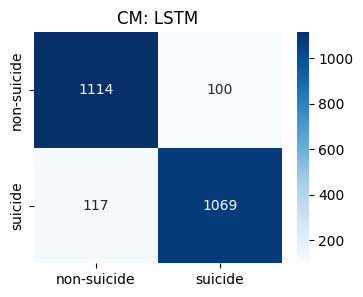

Evaluating DistilBERT...



--- DistilBERT Classification Report ---
              precision    recall  f1-score   support

 non-suicide       0.97      0.96      0.96      1214
     suicide       0.96      0.97      0.96      1186

    accuracy                           0.96      2400
   macro avg       0.96      0.96      0.96      2400
weighted avg       0.96      0.96      0.96      2400



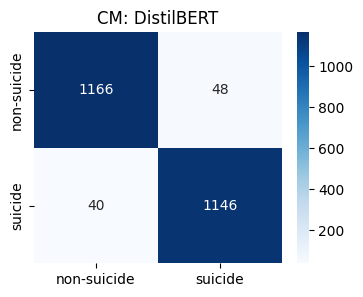

Evaluating RoBERTa...



--- RoBERTa Classification Report ---
              precision    recall  f1-score   support

 non-suicide       0.96      0.97      0.96      1214
     suicide       0.97      0.95      0.96      1186

    accuracy                           0.96      2400
   macro avg       0.96      0.96      0.96      2400
weighted avg       0.96      0.96      0.96      2400



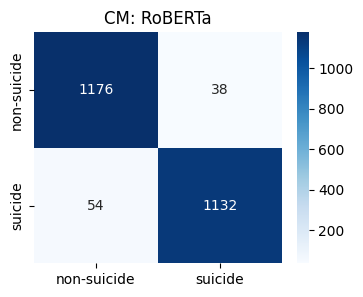

In [ ]:
test_db = SuicideDataset(test_enc_db, y_test)
test_rb = SuicideDataset(test_enc_rb, y_test)

def get_eval(y_true, y_pred, name):
    print(f"\n--- {name} Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"CM: {name}")
    plt.show()

# 1. Prediksi LSTM
print("Evaluating LSTM...")
y_pred_lstm = (model_lstm.predict(X_test_lstm) > 0.5).astype("int32")
get_eval(y_test, y_pred_lstm, "LSTM")

# 2. Prediksi DistilBERT
print("Evaluating DistilBERT...")
raw_db, _, _ = trainer_db.predict(test_db)
get_eval(y_test, np.argmax(raw_db, axis=1), "DistilBERT")

# 3. Prediksi RoBERTa
print("Evaluating RoBERTa...")
raw_rb, _, _ = trainer_rb.predict(test_rb)
get_eval(y_test, np.argmax(raw_rb, axis=1), "RoBERTa")

## Grafik LSTM

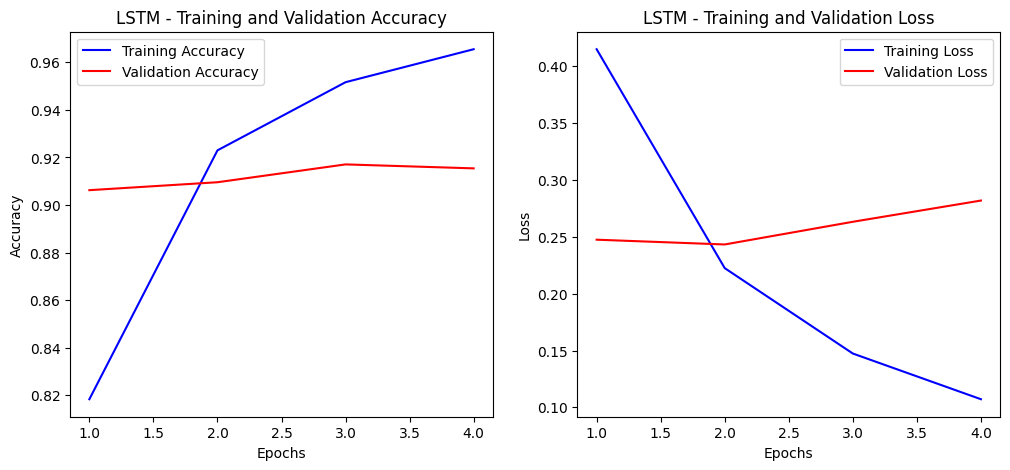

In [ ]:
def plot_history_lstm(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Grafik Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('LSTM - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('LSTM - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Panggil fungsi kembali
plot_history_lstm(history_lstm)

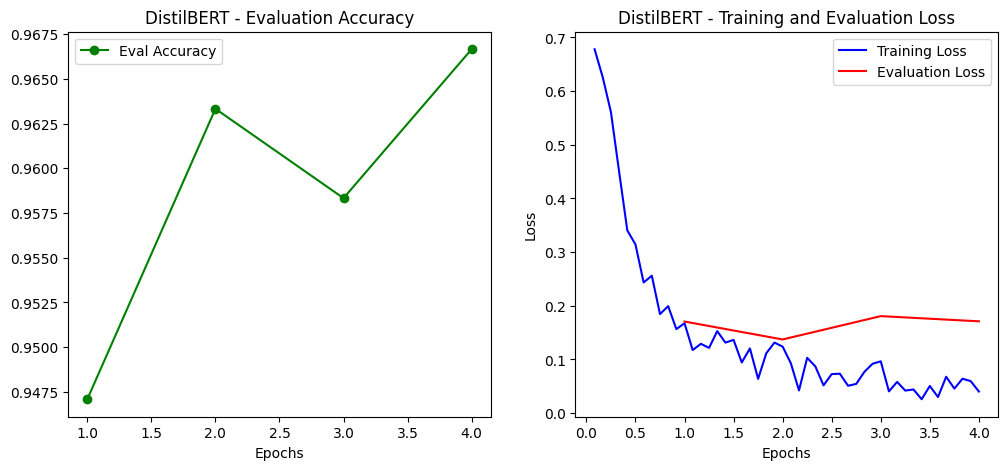

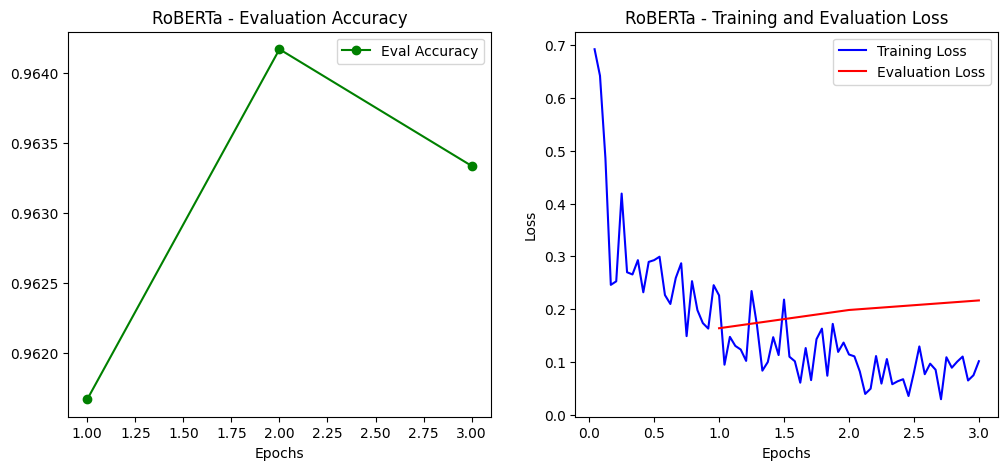

In [ ]:
def plot_hf_history(trainer, model_name):
    history = trainer.state.log_history

    # Ekstraksi data secara aman
    train_loss = [log['loss'] for log in history if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
    eval_acc = [log['eval_accuracy'] for log in history if 'eval_accuracy' in log]
    epochs_train = [log['epoch'] for log in history if 'loss' in log]
    epochs_eval = [log['epoch'] for log in history if 'eval_loss' in log]

    plt.figure(figsize=(12, 5))

    # Grafik Akurasi (Hanya gambar jika datanya ada)
    plt.subplot(1, 2, 1)
    if len(eval_acc) > 0:
        plt.plot(epochs_eval, eval_acc, 'g-o', label='Eval Accuracy')
        plt.title(f'{model_name} - Evaluation Accuracy')
    else:
        plt.text(0.5, 0.5, 'Accuracy data not found.\n(compute_metrics was not defined)',
                 ha='center', va='center')
        plt.title(f'{model_name} - Accuracy (Empty)')
    plt.xlabel('Epochs')
    plt.legend()

    # Grafik Loss
    plt.subplot(1, 2, 2)
    if len(train_loss) > 0:
        plt.plot(epochs_train, train_loss, 'b', label='Training Loss')
    if len(eval_loss) > 0:
        plt.plot(epochs_eval, eval_loss, 'r', label='Evaluation Loss')
    plt.title(f'{model_name} - Training and Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Jalankan ulang
plot_hf_history(trainer_db, "DistilBERT")
plot_hf_history(trainer_rb, "RoBERTa")

# SAVE MODEL

In [ ]:
# Simpan Model LSTM (Format H5)
model_lstm.save('model_lstm.h5')

# Simpan Tokenizer LSTM (Format Pickle)
import pickle
with open('tokenizer_lstm.pkl', 'wb') as f:
    pickle.dump(tokenizer_lstm, f)

print("LSTM Model & Tokenizer Saved!")

LSTM Model & Tokenizer Saved!


In [ ]:
# Membuat folder dan menyimpan model + tokenizer
model_db.save_pretrained("model_distilbert")
tokenizer_db.save_pretrained("model_distilbert")

print("DistilBERT Folder Saved!")

DistilBERT Folder Saved!


In [ ]:
# Membuat folder dan menyimpan model + tokenizer
model_rb.save_pretrained("model_roberta")
tokenizer_rb.save_pretrained("model_roberta")

print("RoBERTa Folder Saved!")

RoBERTa Folder Saved!


In [ ]:
# Simpan Label Encoder (Format Pickle)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Label Encoder Saved!")

Label Encoder Saved!


In [ ]:
# Kompres folder model menjadi ZIP agar bisa didownload
!zip -r model_distilbert.zip model_distilbert
!zip -r model_roberta.zip model_roberta

print("Folders Zipped! Sekarang Anda bisa mendownload file .zip-nya.")

  adding: model_distilbert/ (stored 0%)
  adding: model_distilbert/special_tokens_map.json (deflated 42%)
  adding: model_distilbert/tokenizer_config.json (deflated 75%)
  adding: model_distilbert/config.json (deflated 45%)
  adding: model_distilbert/vocab.txt (deflated 53%)
  adding: model_distilbert/model.safetensors (deflated 8%)
  adding: model_distilbert/tokenizer.json (deflated 71%)
  adding: model_roberta/ (stored 0%)
  adding: model_roberta/special_tokens_map.json (deflated 52%)
  adding: model_roberta/tokenizer_config.json (deflated 75%)
  adding: model_roberta/config.json (deflated 50%)
  adding: model_roberta/merges.txt (deflated 53%)
  adding: model_roberta/vocab.json (deflated 59%)
  adding: model_roberta/model.safetensors (deflated 12%)
  adding: model_roberta/tokenizer.json (deflated 82%)
Folders Zipped! Sekarang Anda bisa mendownload file .zip-nya.
